# SenCast - Twitter sentiment analysis for stock market direction

## Ticker Data

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline

# Working with Conda env sencast.py34. Verify.
print(sys.executable)

Ticker = pd.read_csv('data/dowjones/table.csv')
Ticker = Ticker.sort_values(by='Date', ascending=[True])

Ticker['gain'] = Ticker['Close'] - Ticker['Open']
Ticker.head()

/Users/chrisg/opt/anaconda2/envs/sencast.py27/bin/python


,Date,Open,High,Low,Close,Volume,Adj Close,gain
20,2016-11-02,18017.720703,18044.150391,17931.890625,17959.640625,88610000,17959.640625,-58.080078
19,2016-11-03,17978.750000,18006.960938,17904.070312,17930.669922,77860000,17930.669922,-48.080078
18,2016-11-04,17928.349609,17986.759766,17883.560547,17888.279297,97760000,17888.279297,-40.070312
17,2016-11-07,17994.640625,18263.300781,17994.640625,18259.599609,93450000,18259.599609,264.958984
16,2016-11-08,18251.380859,18400.500000,18200.750000,18332.740234,79820000,18332.740234,81.359375


## Twitter Data

Using Twitter search API:

```python
import json
import tweepy
from tweepy import OAuthHandler

consumer_key = '...'
consumer_secret = '...'
access_token = '...'
access_secret = '...'
 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret) 
api = tweepy.API(auth)

d = []
with open('tweets.json', 'w') as outfile:
    for tweet in tweepy.Cursor(api.search,q='%23dowjones',since='2016-11-23',until='2016-11-24').items():
        d.append(tweet._json)
    json.dump(d, outfile, sort_keys=True, indent=4, ensure_ascii=True)
```

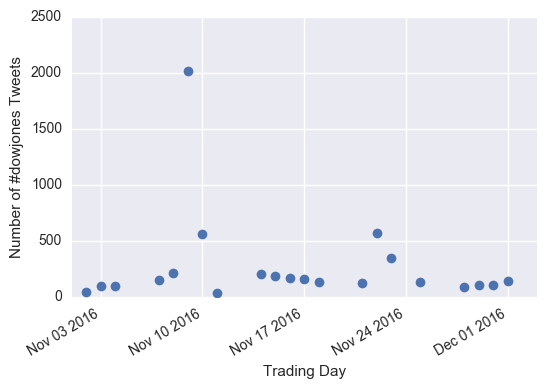

In [2]:
# Show number of tweets per day in sample
import json
from datetime import datetime

lengths=[]
dates=[]
def process_tweets(file):
    with open(file) as data_file:    
        data = json.load(data_file)
    return len(data)
        
for date in Ticker['Date']:
    # convert string to datetime object
    dates.append(datetime.strptime(date,'%Y-%m-%d'))
    tweet_len = process_tweets('./data/dowjones/tweets.searchapi.' + date + '.json')
    lengths.append(tweet_len)
    
ls = pd.Series(lengths,name="tweets",index=dates)

fig, ax = plt.subplots()
ax.plot_date(dates, ls)
ax.set_xlim(datetime.strptime('2016-11-01','%Y-%m-%d'),
           datetime.strptime('2016-12-03','%Y-%m-%d'))
plt.xlabel("Trading Day")
plt.ylabel("Number of #dowjones Tweets")
fig.autofmt_xdate()
# Save before show. Otherwise empty png.
plt.savefig('tdays.png')
plt.show()

## Unsupervised Approach for Sentiment Analysis

In [42]:
import opinion
import operator 
import math
import re
import string
from collections import Counter
from nltk.corpus import stopwords

punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt', 'via']

emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
# preserve tokens
# lowercase if text
def preprocess(s, lowercase=True):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

from collections import defaultdict
from collections import namedtuple

def get_counters(file):
    # co-occurence matrix
    com = defaultdict(lambda : defaultdict(int))
    count_only_single = Counter()
    counters = namedtuple('Counters', ['com', 'count_only_single'])
    with open(file) as data_file:    
        data = json.load(data_file)
    
        for tweet in data:

            # Preprocess tweets and filter stop words
            terms_only = [term for term in preprocess(tweet['text']) 
                          if term not in stop
                          and not term.startswith(('#', '@', 'https:'))] 

            terms_only_single = set(terms_only)

            # Build co-occurrence matrix
            for i in range(len(terms_only)-1):            
                for j in range(i+1, len(terms_only)):
                    w1, w2 = sorted([terms_only[i], terms_only[j]])                
                    if w1 != w2:
                        com[w1][w2] += 1

            # Update the counter
            count_only_single.update(terms_only_single)
        cnt = counters(com, count_only_single)
            
    return cnt

def get_pmi(cnt):
    com = cnt.com
    count_only_single = cnt.count_only_single
    pmipt = namedtuple('Pmipt', ['pmi','p_t'])
    p_t = {}
    p_t_com = defaultdict(lambda : defaultdict(int))

    n_docs = sum(count_only_single.values())

    for term, n in count_only_single.items():
        p_t[term] = n / float(n_docs)
        for t2 in com[term]:
            p_t_com[term][t2] = com[term][t2] / float(n_docs)

    pmi = defaultdict(lambda : defaultdict(int))

    for t1 in p_t:
        for t2 in com[t1]:
            denom = p_t[t1] * p_t[t2]
            pmi[t1][t2] = math.log(p_t_com[t1][t2] / denom, 2)
    pt = pmipt(pmi, p_t)
    return pt

def get_orientation(pt):
    pmi = pt.pmi
    p_t = pt.p_t
    semantic_orientation = {}
    
    for term, n in p_t.items():
        positive_assoc = sum(pmi[term][tx] for tx in opinion.positive_words)
        negative_assoc = sum(pmi[term][tx] for tx in opinion.negative_words)
        semantic_orientation[term] = positive_assoc - negative_assoc
    
    return sum(semantic_orientation.values())

orientations = []
for date in Ticker['Date']:
    orientations.append(get_orientation(get_pmi(get_counters('./data/dowjones/tweets.searchapi.' + date + '.json'))))

Ticker['SO'] = orientations
Ticker['sign'] = np.sign(Ticker['gain'])
Ticker['match_so'] = Ticker['sign'] == np.sign(Ticker['SO'])
score_so = Ticker['match_so'].value_counts()

print(Ticker[['Date','gain','SO','match_so']])
print("\nScore Unsupervised:   %s (%.2f%%)" % (score_so.get(True),100*score_so.get(True)/float(len(Ticker))))

# gain = gain (or loss) of DowJones
# SO = semantic orientation
# match_so = True if SO and gain directions match, 
#           False if SO and gain directions do not match

          Date        gain           SO match_so
20  2016-11-02  -58.080078   166.060717    False
19  2016-11-03  -48.080078   404.780957    False
18  2016-11-04  -40.070312   638.268249    False
17  2016-11-07  264.958984   341.378936     True
16  2016-11-08   81.359375  1115.193898     True
15  2016-11-09  272.429687  3176.102345     True
14  2016-11-10  204.740234   133.272472     True
13  2016-11-11   66.009765   247.038761     True
12  2016-11-14   -8.080078   272.724391    False
11  2016-11-15   64.849609   962.345663     True
10  2016-11-16  -41.708984   790.117311    False
9   2016-11-17   37.599609   397.586906     True
8   2016-11-18  -37.400390    34.941611    False
7   2016-11-21   58.009765    -1.104000    False
6   2016-11-22   53.478516  1202.734479     True
5   2016-11-23   67.660157   231.070613     True
4   2016-11-25   58.419922   161.294869     True
3   2016-11-28  -24.240234   142.067622    False
2   2016-11-29   57.529297   107.123092     True
1   2016-11-30  -12.

## Supervised Learning Approach for Sentiment Analysis

### Acquisition of Sanders Corpus

*** Sanders corpus ***
           irrelevant  negative  neutral  positive
apple             122       277      461       125
google            448        42      529       176
microsoft         433       116      581        82
twitter           474        47      478        46


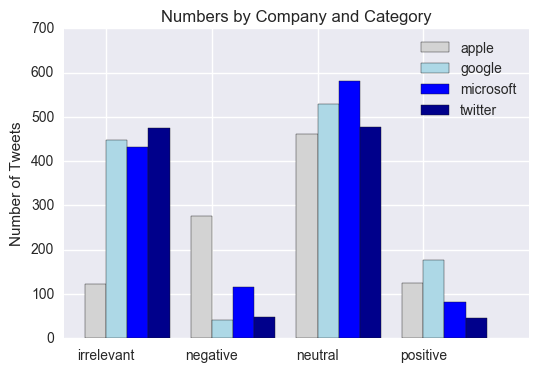

In [33]:
from collections import defaultdict

Tweets = pd.read_csv('./data/sanders/full-corpus.csv')
    
topics = Tweets['Topic']
tweets = Tweets['TweetText']
labels = Tweets['Sentiment']

companies = np.unique(topics)
classes = np.unique(labels)
print("*** Sanders corpus ***")

# Query format for DF 
# Tweets.query("(Topic == 'apple') & (Sentiment == 'positive')")

statsdf = pd.DataFrame()

for co in companies:
    #print co
    stats = {}
    for c in classes:
        qstring = "(Topic == '%s') & (Sentiment == '%s')" % (co,c)
        #print qstring
        key = (co,c)
        #print key
        stats[c] = len(Tweets.query(qstring))
         
    #print stats
    df1 = pd.DataFrame(data=stats,index=[co])
    #print df1
    statsdf = statsdf.append(df1)

print statsdf

fig = plt.figure()
ax = fig.add_subplot(111)

N = 4
ind = np.arange(N)
width = 0.20

rects1 = ax.bar(ind, statsdf.loc['apple'], width, color='lightgray')
rects2 = ax.bar(ind+width, statsdf.loc['google'], width, color='lightblue')
rects3 = ax.bar(ind+2*width, statsdf.loc['microsoft'], width, color='blue')
rects4 = ax.bar(ind+3*width, statsdf.loc['twitter'], width, color='darkblue')

ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,700)
ax.set_ylabel('Number of Tweets')
ax.set_title('Numbers by Company and Category')
xTickMarks = ['irrelevant','negative','neutral','positive']
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
#plt.setp(xtickNames, rotation=45, fontsize=10)
ax.legend( (rects1[0], rects2[0], rects3[0], rects4[0]), 
          ('apple', 'google', 'microsoft', 'twitter') )

plt.savefig('sandersstats.png')
plt.show()

### First assessment using Multinomial Naive Bayes classifier



In [37]:
import os
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score
from sklearn import cross_validation

def processTweet(tweet):
    # process the tweets
    #Convert to lower case
    tweet = tweet.lower()
    #print(tweet)
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','AT_USER',tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #trim
    tweet = tweet.strip('\'"')
    return tweet
    
    
seed = 1234
tweets = tweets.apply(processTweet)
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(tweets,labels,
                                                                         train_size=0.8,
                                                                         stratify=labels,
                                                                         random_state=seed)
                
# Apply Tf-Idf transformation                
vectorizer = TfidfVectorizer(min_df= 2, max_df = 0.9, sublinear_tf=True, use_idf=True)
train_vectors = vectorizer.fit_transform(train_data)
test_vectors = vectorizer.transform(test_data)

# Use decorators to time training and prediction
def timeTr(f):
    def new_f(clf,data,labels):
        t0 = time.time()
        f(clf,data,labels)
        t1 = time.time()
        return t1-t0
    return new_f

def timePr(f):
    def new_f(clf,data):
        t0 = time.time()
        pred = f(clf,data)
        t1 = time.time()
        return (t1-t0, pred)
    return new_f

@timeTr
def trainer(clf,data,labels):
    clf.fit(data,labels)

@timePr
def predictor(clf,data):
    pred = clf.predict(data)
    return pred
    
train_vectors_nparray = train_vectors.toarray()
test_vectors_nparray = test_vectors.toarray()
    
# Try Naive Bayes    
from sklearn.naive_bayes import MultinomialNB

classifier_mn = MultinomialNB(alpha=0.01, fit_prior=True)
time_mn_train = trainer(classifier_mn,train_vectors_nparray, train_labels)
time_mn_predict, prediction_mn = predictor(classifier_mn, test_vectors_nparray)

# Print results in a nice table
print
print("F1 scores by class:    %s" % classes)    
print("F1 MultinomialNB():    %s \n(train: %fsec predict: %fsec)" % 
        (f1_score(test_labels, prediction_mn, average=None), 
         time_mn_train, time_mn_predict))


F1 scores by class:    ['irrelevant' 'negative' 'neutral' 'positive']
F1 MultinomialNB():    [ 0.87477314  0.5398773   0.77813505  0.31007752] 
(train: 0.031031sec predict: 0.002988sec)


### Positive vs. Negative


*** Results for MultinomialNB() ***

Accuracy: 0.781420765027  (fraction of correctly classified samples)

Classification report:
             precision    recall  f1-score   support

   negative       0.79      0.80      0.80        97
   positive       0.77      0.76      0.76        86

avg / total       0.78      0.78      0.78       183


P/R curve (precision/recall) with AUC=0.849935530908 (area under curve = average precision):


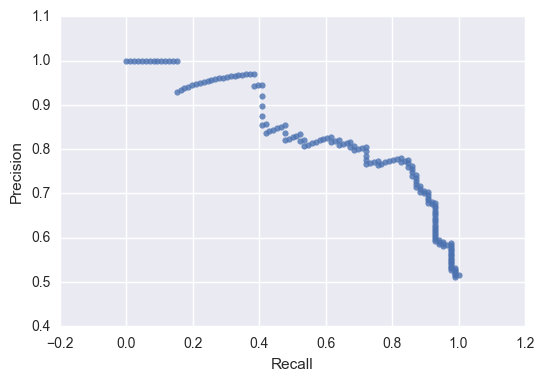

In [6]:
from sklearn.metrics import precision_recall_curve, auc

# Find all pos and neg labels by index
pos_neg_idx = np.logical_or(labels=="positive", labels=="negative")

# Select only pos and neg tweets
tweets_posneg = tweets[pos_neg_idx]
labels_posneg = labels[pos_neg_idx]

train_data_pn, test_data_pn, train_labels_pn, test_labels_pn = cross_validation.train_test_split(tweets_posneg,
                                                                                     labels_posneg,
                                                                                     train_size=0.8,
                                                                                     stratify=labels_posneg,
                                                                                     random_state=seed)
                    
                    
# Apply Tf-Idf vectorization
train_vectors_pn = vectorizer.transform(train_data_pn)
test_vectors_pn = vectorizer.transform(test_data_pn)

# Convert to nparray
train_vectors_pn_nparray = train_vectors_pn.toarray()
test_vectors_pn_nparray = test_vectors_pn.toarray()

# Train MultinomialNB()
print("\n*** Results for MultinomialNB() ***")
classifier_mn.fit(train_vectors_pn_nparray, train_labels_pn)
prediction_mn = classifier_mn.predict(test_vectors_pn_nparray)
score_mn = classifier_mn.score(test_vectors_pn_nparray, test_labels_pn)
print("\nAccuracy: %s  (fraction of correctly classified samples)" % score_mn)
print("\nClassification report:")
print(classification_report(test_labels_pn, prediction_mn))

# Plot Precision/Recall curve for MultinomialNB()
proba_mn = classifier_mn.predict_proba(test_vectors_pn_nparray)
precision, recall, _ = precision_recall_curve(test_labels_pn, proba_mn[:,1],pos_label="positive")
auc_mn = auc(recall, precision)

precision_s = pd.Series(precision,name='Precision')
recall_s = pd.Series(recall,name='Recall')
print("\nP/R curve (precision/recall) with AUC=%s (area under curve = average precision):" % auc_mn)
regplot = sns.regplot(x=recall_s,y=precision_s,fit_reg=False)
plt.savefig("fig1.png")

### Positive vs. Negative Crossvalidation

acc = accuracy (fraction of correctly classified samples)
auc = area under curve (average precision)

acc             auc
mean    std     mean    std
0.781	0.000	0.864	0.000
0.792	0.011	0.873	0.009
0.775	0.026	0.870	0.009
0.775	0.023	0.867	0.009
0.786	0.030	0.874	0.016
0.784	0.028	0.866	0.024
0.783	0.026	0.869	0.023
0.785	0.025	0.875	0.027
0.785	0.023	0.876	0.025
0.781	0.026	0.872	0.026

*** Positive vs. Negative MultinomialNB() ***
Final mean acc: 0.780821917808
Final mean auc: 0.872453456064


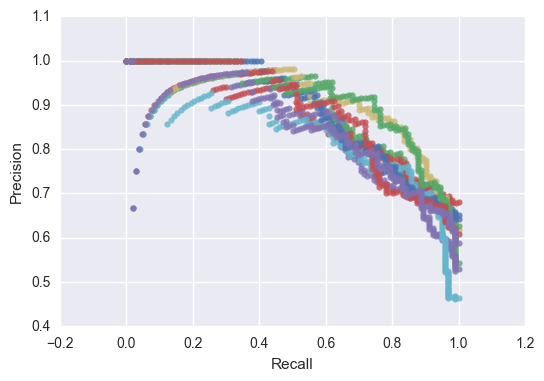

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, auc
from sklearn.cross_validation import ShuffleSplit

emo_repl = {
    # positive emoticons
    "&lt;3": " good ",
    ":d": " good ", # :D in lower case
    ":dd": " good ", # :DD in lower case
    "8)": " good ",
    ":-)": " good ",
    ":)": " good ",
    ";)": " good ",
    "(-:": " good ",
    "(:": " good ",
    # negative emoticons:
    ":/": " bad ",
    ":&gt;": " sad ",
    ":')": " sad ",
    ":-(": " bad ",
    ":(": " bad ",
    ":S": " bad ",
    ":-S": " bad ",
    }
# make sure that e.g. :dd is replaced before :d
emo_repl_order = [k for (k_len,k) in reversed(sorted([(len(k),k) for k in emo_repl.keys()]))]

re_repl = {
    r"\br\b": "are",
    r"\bu\b": "you",
    r"\bhaha\b": "ha",
    r"\bhahaha\b": "ha",
    r"\bdon't\b": "do not",
    r"\bdoesn't\b": "does not",
    r"\bdidn't\b": "did not",
    r"\bhasn't\b": "has not",
    r"\bhaven't\b": "have not",
    r"\bhadn't\b": "had not",
    r"\bwon't\b": "will not",
    r"\bwouldn't\b": "would not",
    r"\bcan't\b": "can not",
    r"\bcannot\b": "can not",
}

def preprocessor(tweet):
    tweet = tweet.lower()
    for k in emo_repl_order:
        tweet = tweet.replace(k, emo_repl[k])
    for r, repl in re_repl.items():
        tweet = re.sub(r, repl, tweet)
    return tweet

def create_ngram_model():
        
    tfidf_ngrams = TfidfVectorizer(preprocessor=preprocessor,
                                   ngram_range=(1,3),
                                   analyzer="word",
                                   binary=False)
    
    clf = MultinomialNB()
    return Pipeline([('vect', tfidf_ngrams), ('clf', clf)])

def create_ngram_linear_model():
    tfidf_ngrams = TfidfVectorizer(ngram_range=(1,3),
                                  analyzer="word",
                                  binary=False)
    
    clf = svm.LinearSVC()
    return Pipeline([('vect', tfidf_ngrams), ('clf', clf)])

def train_model(clf_factory, X, Y, getproba=True, plotpr=False):
    
    cv = ShuffleSplit(n=len(X), n_iter=10, test_size=0.3, random_state=seed)
    
    scores = []
    pr_scores = []
    
    for train, test in cv:
        X_train, y_train = X[train], Y[train]
        X_test, y_test = X[test], Y[test]
        
        clf = clf_factory()
        clf.fit(X_train, y_train)
        
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        scores.append(test_score)
        
        if getproba == True:
            proba = clf.predict_proba(X_test)
            precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:,1])
            pr_scores.append(auc(recall, precision))
        
            summary = (np.mean(scores), np.std(scores), np.mean(pr_scores), np.std(pr_scores))
            print("%.3f\t%.3f\t%.3f\t%.3f" % summary)
            
            if plotpr == True:
                precision_s = pd.Series(precision,name='Precision')
                recall_s = pd.Series(recall,name='Recall')
                _ = sns.regplot(x=recall_s,y=precision_s,fit_reg=False)
                plt.savefig("fig2.png")
            
        else:
        
            summary = (np.mean(scores), np.std(scores))
            print("%.3f\t%.3f" % summary)
        
    return scores, pr_scores
        
# Make binary labels
d = {'positive': True, 'negative': False}
train_labels_pn_binary = train_labels_pn.map(d)

# Use continuous index or it'll break in train_model().
train_data_pn.index = np.arange(0,len(train_data_pn))
train_labels_pn_binary.index = np.arange(0,len(train_labels_pn_binary))

print("acc = accuracy (fraction of correctly classified samples)")
print("auc = area under curve (average precision)")

print
print("acc             auc")
print("mean    std     mean    std")
scores, pr_scores = train_model(create_ngram_model, train_data_pn, train_labels_pn_binary, plotpr=True)
print("\n*** Positive vs. Negative MultinomialNB() ***")
print("Final mean acc: %s" % np.mean(scores))
print("Final mean auc: %s" % np.mean(pr_scores))

### Positive/Negative vs. Irrelevant/Neutral Crossvalidation

0.804	0.000	0.600	0.000
0.792	0.011	0.625	0.025
0.796	0.010	0.633	0.024
0.796	0.009	0.632	0.021
0.797	0.008	0.626	0.022
0.797	0.008	0.625	0.020
0.797	0.007	0.626	0.019
0.796	0.007	0.621	0.022
0.797	0.007	0.623	0.022
0.797	0.007	0.626	0.023

*** Positive/Negative vs. Irrelevant/Neutral ***
Final mean acc: 0.797370892019
Final mean auc: 0.626437147662


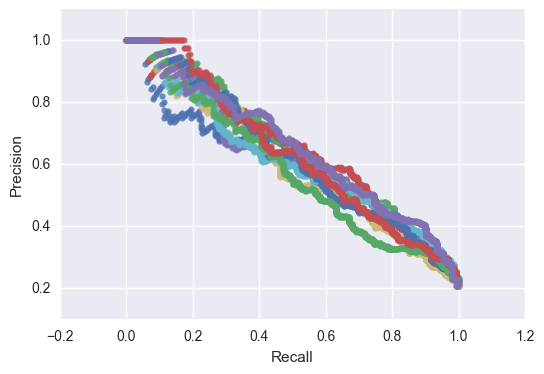

In [47]:
# Look at pos/neg against irrelevant/neutral
d = {'positive': True, 'negative': True, 'irrelevant': False, 'neutral': False}
train_labels_tweak_binary = train_labels.map(d)

# Use continuous index
train_data.index = np.arange(0,len(train_data))
train_labels_tweak_binary.index = np.arange(0,len(train_labels_tweak_binary))

scores, pr_scores = train_model(create_ngram_model, train_data, train_labels_tweak_binary, plotpr=True)
print("\n*** Positive/Negative vs. Irrelevant/Neutral ***")
print("Final mean acc: %s" % np.mean(scores))
print("Final mean auc: %s" % np.mean(pr_scores))

### Positive vs. Rest Crossvalidation

0.898	0.000	0.208	0.000
0.895	0.003	0.252	0.044
0.896	0.003	0.267	0.041
0.899	0.005	0.270	0.036
0.897	0.005	0.261	0.037
0.898	0.005	0.262	0.033
0.900	0.007	0.269	0.035
0.900	0.006	0.269	0.033
0.900	0.006	0.267	0.032
0.900	0.006	0.268	0.030

*** Positive vs. Rest ***
Final mean acc: 0.900281690141
Final mean auc: 0.268431069987


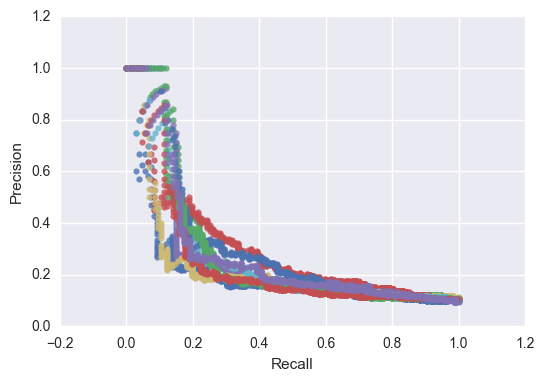

In [48]:
# Look at pos against neg/irrelevant/neutral
d = {'positive': True, 'negative': False, 'irrelevant': False, 'neutral': False}
train_labels_tweak_binary = train_labels.map(d)

# Use continuous index
train_labels_tweak_binary.index = np.arange(0,len(train_labels_tweak_binary))

scores, pr_scores = train_model(create_ngram_model, train_data, train_labels_tweak_binary, plotpr=True)
print("\n*** Positive vs. Rest ***")
print("Final mean acc: %s" % np.mean(scores))
print("Final mean auc: %s" % np.mean(pr_scores))

### Negative vs. Rest Crossvalidation

0.900	0.000	0.417	0.000
0.894	0.007	0.398	0.019
0.895	0.006	0.396	0.016
0.893	0.006	0.384	0.024
0.896	0.008	0.405	0.047
0.895	0.008	0.400	0.044
0.894	0.008	0.398	0.041
0.893	0.008	0.392	0.041
0.893	0.007	0.398	0.041
0.893	0.007	0.400	0.040

*** Negative vs. Rest ***
Final mean acc: 0.893051643192
Final mean auc: 0.400309496678


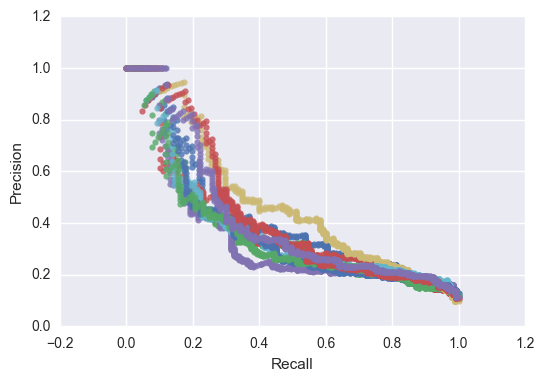

In [49]:
# Look at neg against pos/irrelevant/neutral
d = {'positive': False, 'negative': True, 'irrelevant': False, 'neutral': False}
train_labels_tweak_binary = train_labels.map(d)

# Use continuous index
train_labels_tweak_binary.index = np.arange(0,len(train_labels_tweak_binary))

scores, pr_scores = train_model(create_ngram_model, train_data, train_labels_tweak_binary, plotpr=True)
print("\n*** Negative vs. Rest ***")
print("Final mean acc: %s" % np.mean(scores))
print("Final mean auc: %s" % np.mean(pr_scores))

### Positive vs. Negative Hyperparameter Training

In [12]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score

def grid_search_model(clf_factory, X, Y):
    
    cv = ShuffleSplit(n=len(X), n_iter=10, test_size=0.3, random_state=0)
    
    param_grid = dict(vect__ngram_range=[(1,1), (1,2), (1,3)],
                      vect__min_df=[1,2],
                      vect__stop_words=[None, "english"],
                      vect__smooth_idf=[False, True],
                      vect__use_idf=[False, True],
                      vect__sublinear_tf=[False, True],
                      vect__binary=[False, True],
                      clf__alpha=[0, 0.01, 0.05, 0.1, 1]
                     )
    
    grid_search = GridSearchCV(clf_factory(),
                              param_grid=param_grid,
                              cv=cv,
                              verbose=1,
                              )
    
    grid_search.fit(X, Y)
    return grid_search

#print(create_ngram_model().get_params().keys())

In [16]:
# WARNING: Running grid search takes ~15 min
# NOTE: You can skip this step and use the hardcoded best estimator from the next cell
clf = grid_search_model(create_ngram_model, train_data_pn, train_labels_pn_binary)
print("\n*** Best estimator ***")
print("score: %s" % clf.best_score_)
print("params: %s" % clf.best_params_)
print("scorer: %s" % clf.scorer_)
be = clf.best_estimator_

Fitting 10 folds for each of 960 candidates, totalling 9600 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   14.4s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:   40.2s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done 1249 tasks       | elapsed:  1.8min
[Parallel(n_jobs=1)]: Done 1799 tasks       | elapsed:  2.7min
[Parallel(n_jobs=1)]: Done 2449 tasks       | elapsed:  3.6min
[Parallel(n_jobs=1)]: Done 3199 tasks       | elapsed:  4.7min
[Parallel(n_jobs=1)]: Done 4049 tasks       | elapsed:  6.0min
[Parallel(n_jobs=1)]: Done 4999 tasks       | elapsed:  7.4min
[Parallel(n_jobs=1)]: Done 6049 tasks       | elapsed:  9.0min
[Parallel(n_jobs=1)]: Done 7199 tasks       | elapsed: 10.8min
[Parallel(n_jobs=1)]: Done 8449 tasks       | elapsed: 12.6min



*** Best estimator ***
score: 0.809132420091
params: {'vect__ngram_range': (1, 1), 'vect__smooth_idf': True, 'vect__sublinear_tf': False, 'vect__binary': False, 'vect__min_df': 1, 'vect__stop_words': None, 'vect__use_idf': True, 'clf__alpha': 0.1}
scorer: <function _passthrough_scorer at 0x11a2332a8>


[Parallel(n_jobs=1)]: Done 9600 out of 9600 | elapsed: 14.4min finished


In [13]:
# NOTE: Use hardcoded best estimator
def create_be():
          
    tfidf_ngrams = TfidfVectorizer(preprocessor=preprocessor,
                                   ngram_range=(1,1),
                                  analyzer="word",
                                  binary=False,
                                  smooth_idf=True,
                                  use_idf=True,
                                  min_df=1,
                                  stop_words=None,
                                  sublinear_tf=False,
                                  )
    
    clf = MultinomialNB(alpha=0.1)
    
    return Pipeline([('vect', tfidf_ngrams), ('clf', clf)])

# hard-coded, so you can skip generation step.
be = create_be()
be.fit(train_data_pn,train_labels_pn_binary)

Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2',
        preprocessor=<function prep...se_idf=True, vocabulary=None)), ('clf', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))])

### Assessing Best Positive vs. Negative Classifier


Accuracy: 0.830601092896  (fraction of correctly classified samples)

Classification report:
             precision    recall  f1-score   support

      False       0.84      0.84      0.84        97
       True       0.82      0.83      0.82        86

avg / total       0.83      0.83      0.83       183


P/R curve (precision/recall) with AUC=0.870800193699 (area under curve = average precision):


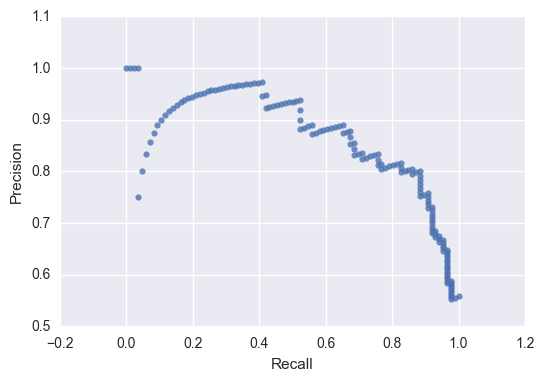

In [43]:
# Make binary labels
d = {'positive': True, 'negative': False}
test_labels_pn_binary = test_labels_pn.map(d)

# Use continuous index or it'll break in train_model().
test_data_pn.index = np.arange(0,len(test_data_pn))
test_labels_pn_binary.index = np.arange(0,len(test_labels_pn_binary))
#print(test_data_pn.shape)
#print(test_labels_pn_binary.shape)

#train_data_pn.index = np.arange(0,len(train_data_pn))
#train_labels_pn_binary.index = np.arange(0,len(train_labels_pn_binary))

prediction_gs1 = be.predict(test_data_pn)
score_gs1 = be.score(test_data_pn, test_labels_pn_binary)
print("\nAccuracy: %s  (fraction of correctly classified samples)" % score_gs1)
print("\nClassification report:")
print(classification_report(test_labels_pn_binary, prediction_gs1))

# Plot Precision/Recall curve for MultinomialNB()
#print(test_vectors_pn_nparray)
proba_gs1 = be.predict_proba(test_data_pn)
precision, recall, _ = precision_recall_curve(test_labels_pn_binary, proba_gs1[:,1])
auc_gs1 = auc(recall, precision)

precision_s = pd.Series(precision,name='Precision')
recall_s = pd.Series(recall,name='Recall')
print("\nP/R curve (precision/recall) with AUC=%s (area under curve = average precision):" % auc_gs1)
_ = sns.regplot(x=recall_s,y=precision_s,fit_reg=False)
plt.savefig("cl2best.png")

### Positive/Negative vs. Irrelevant/Neutral Hyperparameter Training

In [15]:
# Look at pos/neg against irrelevant/neutral
d = {'positive': True, 'negative': True, 'irrelevant': False, 'neutral': False}
train_labels_tweak_binary = train_labels.map(d)

# Use continuous index
#train_data.index = np.arange(0,len(train_data))
train_labels_tweak_binary.index = np.arange(0,len(train_labels_tweak_binary))

In [20]:
# WARNING: Running grid search takes ~60 min
# NOTE: You can skip this step and use the hardcoded best estimator from the next cell
clf2 = grid_search_model(create_ngram_model, train_data, train_labels_tweak_binary)
print("\n*** Best estimator ***")
print("score: %s" % clf2.best_score_)
print("params: %s" % clf2.best_params_)
print("scorer: %s" % clf2.scorer_)
be2 = clf2.best_estimator_

Fitting 10 folds for each of 960 candidates, totalling 9600 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   13.5s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:  1.0min
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:  3.0min
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:  5.1min
[Parallel(n_jobs=1)]: Done 1249 tasks       | elapsed:  8.3min
[Parallel(n_jobs=1)]: Done 1799 tasks       | elapsed: 12.2min
[Parallel(n_jobs=1)]: Done 2449 tasks       | elapsed: 16.8min
[Parallel(n_jobs=1)]: Done 3199 tasks       | elapsed: 21.8min
[Parallel(n_jobs=1)]: Done 4049 tasks       | elapsed: 27.5min
[Parallel(n_jobs=1)]: Done 4999 tasks       | elapsed: 33.9min
[Parallel(n_jobs=1)]: Done 6049 tasks       | elapsed: 41.0min
[Parallel(n_jobs=1)]: Done 7199 tasks       | elapsed: 49.1min
[Parallel(n_jobs=1)]: Done 8449 tasks       | elapsed: 57.2min
[Parallel(n_jobs=1)]: Done 9600 out of 9600 | elapsed: 65.3min finished



*** Best estimator ***
score: 0.84676056338
params: {'vect__ngram_range': (1, 2), 'vect__smooth_idf': False, 'vect__sublinear_tf': True, 'vect__binary': False, 'vect__min_df': 1, 'vect__stop_words': None, 'vect__use_idf': False, 'clf__alpha': 0.1}
scorer: <function _passthrough_scorer at 0x11a2332a8>


In [16]:
# NOTE: Use hardcoded best estimator
def create_be2():
    
    def preprocessor(tweet):
        tweet = tweet.lower()
        for k in emo_repl_order:
            tweet = tweet.replace(k, emo_repl[k])
        for r, repl in re_repl.items():
            tweet = re.sub(r, repl, tweet)
        return tweet
    
    tfidf_ngrams = TfidfVectorizer(preprocessor=preprocessor,
                                   ngram_range=(1,2),
                                  analyzer="word",
                                  binary=False,
                                  smooth_idf=False,
                                  use_idf=False,
                                  min_df=1,
                                  stop_words=None,
                                  sublinear_tf=True,
                                  )
    
    clf = MultinomialNB(alpha=0.1)
    return Pipeline([('vect', tfidf_ngrams), ('clf', clf)])

# hard-coded, so you can skip generation step.
be2 = create_be2()

# Look at pos/neg against irrelevant/neutral
d = {'positive': True, 'negative': True, 'irrelevant': False, 'neutral': False}
train_labels_tweak_binary = train_labels.map(d)
train_labels_tweak_binary.index = np.arange(0,len(train_labels_tweak_binary))

be2.fit(train_data,train_labels_tweak_binary)

Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm=u'l2',
        preprocessor=<function prep...e_idf=False, vocabulary=None)), ('clf', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))])

### Assessing Best Positive/Negative vs. Irrelevant/Neutral Classifier


Accuracy: 0.850225225225  (fraction of correctly classified samples)

Classification report:
             precision    recall  f1-score   support

      False       0.87      0.95      0.91       706
       True       0.71      0.46      0.56       182

avg / total       0.84      0.85      0.84       888


P/R curve (precision/recall) with AUC=0.695263347714 (area under curve = average precision):


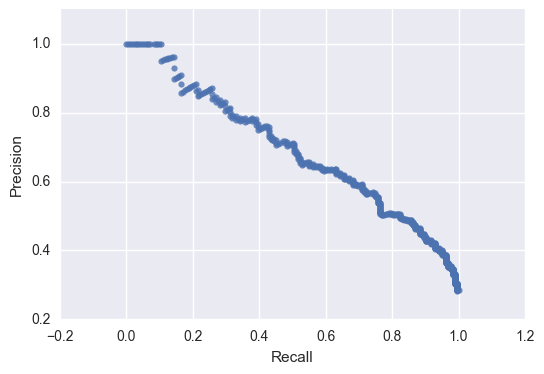

In [44]:
# Make binary labels
d = {'positive': True, 'negative': True, 'irrelevant': False, 'neutral': False}
test_labels_tweak_binary = test_labels.map(d)

# Use continuous index or it'll break in train_model().
test_data.index = np.arange(0,len(test_data))
test_labels_tweak_binary.index = np.arange(0,len(test_labels_tweak_binary))

prediction_gs2 = be2.predict(test_data)
score_gs2 = be2.score(test_data, test_labels_tweak_binary)
print("\nAccuracy: %s  (fraction of correctly classified samples)" % score_gs2)
print("\nClassification report:")
print(classification_report(test_labels_tweak_binary, prediction_gs2))

# Plot Precision/Recall curve for MultinomialNB()
#print(test_vectors_pn_nparray)
proba_gs2 = be2.predict_proba(test_data)
precision, recall, _ = precision_recall_curve(test_labels_tweak_binary, proba_gs2[:,1])
auc_gs2 = auc(recall, precision)

precision_s = pd.Series(precision,name='Precision')
recall_s = pd.Series(recall,name='Recall')
print("\nP/R curve (precision/recall) with AUC=%s (area under curve = average precision):" % auc_gs2)
_ = sns.regplot(x=recall_s,y=precision_s,fit_reg=False)
plt.savefig("cl1best.png")

### Sanders Corpus Classifier Score 

In [31]:
def get_tweets(file,tweak=False):
    
    dow=[]
    with open(file) as data_file:    
        data = json.load(data_file)
        
        for tweet in data:
            terms = tweet['text']
            terms = processTweet(terms)
            terms = preprocessor(terms)
            # Tweak for DowJones
            if tweak == True:
                terms = re.sub(r"dowjones (\w+\s)?up", "GREAT AWESOME LOVE", terms)
                terms = re.sub(r"dowjones (\w+\s)?hit(\w+)? (\w+\s)?high", "GREAT AWESOME LOVE", terms)
                terms = re.sub(r"record high", "GREAT AWESOME LOVE", terms)
                terms = re.sub(r"less risky", "GREAT AWESOME LOVE", terms)
            dow.append(terms)
            
    return dow

sentiment_ml = []
pos_ml = []
neg_ml = []
neutral_ml = []
for date in Ticker['Date']:
    # Do not tweak tweets. Use 'raw' data.
    dow = get_tweets('./data/dowjones/tweets.searchapi.' + date + '.json',tweak=False)
    
    pos = 0
    neg = 0
    neutral = 0
    for t in dow:
        tseries = pd.Series(t)
        tsent = be2.predict(tseries)
        if tsent == True:
            tpos = be.predict(tseries)
            if tpos == True:
                pos += 1
            else:
                neg += 1
        else:
            neutral += 1

    pos_ml.append(pos)
    neg_ml.append(neg)
    neutral_ml.append(neutral)
    sentiment_ml.append(pos - neg)

# create sign w/ neutral entries
Ticker['sign_neutral'] = Ticker['sign']
mask = (Ticker['gain'] > 20) | (Ticker['gain'] < -20)
Ticker['sign_neutral'] = np.where(mask,Ticker['sign_neutral'].values,0)
    
Ticker['sanders'] = sentiment_ml
Ticker['pos_sa'] = pos_ml
Ticker['neg_sa'] = neg_ml
Ticker['neu_sa'] = neutral_ml

sign_sa = np.sign(Ticker['sanders'])
Ticker['match_sa'] = Ticker['sign_neutral'] == sign_sa
score_sr = Ticker['match_sa'].value_counts()

print(Ticker[['Date','gain','sanders','match_sa','pos_sa','neg_sa','neu_sa']])
print("\nScore sanders:   %s (%.2f%%)" % (score_sr.get(True),100*score_sr.get(True)/float(len(Ticker))))

          Date        gain  sanders match_sa  pos_sa  neg_sa  neu_sa
20  2016-11-02  -58.080078       -1     True       0       1      43
19  2016-11-03  -48.080078       -1     True       0       1      96
18  2016-11-04  -40.070312        0    False       1       1      90
17  2016-11-07  264.958984       -1    False       4       5     136
16  2016-11-08   81.359375       -1    False       1       2     211
15  2016-11-09  272.429687      -46    False      68     114    1829
14  2016-11-10  204.740234       -3    False       5       8     545
13  2016-11-11   66.009765       -2    False       0       2      31
12  2016-11-14   -8.080078       -2    False       0       2     197
11  2016-11-15   64.849609        1     True       2       1     185
10  2016-11-16  -41.708984       -3     True       1       4     163
9   2016-11-17   37.599609        0    False       2       2     155
8   2016-11-18  -37.400390        0    False       0       0     133
7   2016-11-21   58.009765       -

### Tweaking Sanders Corpus Classifier

Result due to training on Sanders corpus, which is focussed on products. Make small adjustments for DowJones sentiment.

In [30]:
sentiment_ml = []
pos_ml = []
neg_ml = []
neutral_ml = []
for date in Ticker['Date']:
    # set tweak to True to allow for adjustments
    dow = get_tweets('./data/dowjones/tweets.searchapi.' + date + '.json',tweak=True)    
    pos = 0
    neg = 0
    neutral = 0
    for t in dow:
        tseries = pd.Series(t)
        tsent = be2.predict(tseries)
        if tsent == True:
            tpos = be.predict(tseries)
            if tpos == True:
                pos += 1
            else:
                neg += 1
        else:
            neutral += 1

    pos_ml.append(pos)
    neg_ml.append(neg)
    neutral_ml.append(neutral)
    sentiment_ml.append(pos - neg)


Ticker['sanders'] = sentiment_ml
Ticker['pos_sa'] = pos_ml
Ticker['neg_sa'] = neg_ml
Ticker['neu_sa'] = neutral_ml

sign_sa = np.sign(Ticker['sanders'])
Ticker['match_sa'] = Ticker['sign_neutral'] == sign_sa
score_sa = Ticker['match_sa'].value_counts()

print(Ticker[['Date','gain','sanders','match_sa','pos_sa','neg_sa','neu_sa']])
print("\nScore sanders:   %s (%.2f%%)" % (score_sa.get(True),100*score_sa.get(True)/float(len(Ticker))))

          Date        gain  sanders match_sa  pos_sa  neg_sa  neu_sa
20  2016-11-02  -58.080078       -1     True       0       1      43
19  2016-11-03  -48.080078       -1     True       0       1      96
18  2016-11-04  -40.070312        0    False       1       1      90
17  2016-11-07  264.958984        2     True       7       5     133
16  2016-11-08   81.359375        0    False       2       2     210
15  2016-11-09  272.429687       12     True     121     109    1781
14  2016-11-10  204.740234       57     True      62       5     491
13  2016-11-11   66.009765       -2    False       0       2      31
12  2016-11-14   -8.080078        2    False       3       1     195
11  2016-11-15   64.849609        4     True       5       1     182
10  2016-11-16  -41.708984       -2     True       2       4     162
9   2016-11-17   37.599609        2     True       3       1     155
8   2016-11-18  -37.400390        0    False       0       0     133
7   2016-11-21   58.009765       -

## API based approach for Sentiment Analysis with Sentiment140

```python
# Convert twitter JSON to sentiment140 JSON
# Execute once
import json

def get_tweets_bulk(file):
    minilst=[]
    with open(file) as data_file:
        data = json.load(data_file)
        for tweet in data:
            mini={}
            mini['id'] = tweet['id']
            mini['query'] = 'dowjones'
            text = tweet['text']
            text = text.replace("'", "") 
            mini['text'] = text
            minilst.append(mini)
            
    return minilst

bulk = {}
bulk['language'] = 'auto'
for date in Ticker['Date']:
    dow = get_tweets_bulk('./data/dowjones/tweets.searchapi.' + date + '.json')
    bulk['data'] = dow
    outname = './data/json/bulk.' + date + '.json'
    with open(outname, 'w') as outfile:
        json.dump(bulk, outfile, ensure_ascii=True)
```

```sh
#!/bin/bash

bulkfile=`ls ./data/json`

for f in $bulkfile
do
    echo "Processing " $f "..."
    filepath='./data/json/'$f
    echo $filepath
    result=`curl --data @${filepath} http://www.sentiment140.com/api/bulkClassifyJson?appid=<YOUR_EMAIL>`
    echo $result > ./data/json140/$f
    sleep 10
done
```

### Sentiment140 Classifier Score

The polarity values returned in JSON are:

- 0: negative
- 2: neutral
- 4: positive

In [28]:
import io

pos140=[]
neg140=[]
neutral140=[]
sent140=[]

for date in Ticker['Date']:
    inname = './data/json140/bulk.' + date + '.json'
    with io.open(inname, 'r', encoding='latin-1') as infile:
        pol = json.load(infile)
        tweets = pol['data']
        pos=0
        neg=0
        neutral=0
        for t in tweets:
            pol = t['polarity']
            if pol == 2:
                neutral += 1
            elif pol == 0:
                neg += 1
            elif pol == 4:
                pos += 1
        #print("pos: %s  neg: %s  neutral: %s" % (pos,neg,neutral))
        pos140.append(pos)
        neg140.append(neg)
        neutral140.append(neutral)
        sent140.append(pos-neg)
                
Ticker['s140'] = sent140
Ticker['pos_140'] = pos140
Ticker['neg_140'] = neg140
Ticker['neu_140'] = neutral140

# sign function does return 0 for 0
sign_140 = np.sign(Ticker['s140'])
Ticker['match_140'] = Ticker['sign_neutral'] == sign_140
score_140 = Ticker['match_140'].value_counts()

print(Ticker[['Date','gain','s140','match_140', 'pos_140', 'neg_140', 'neu_140']])
print("\nScore sentiment140:   %s (%.2f%%)" % (score_140.get(True),100*score_140.get(True)/float(len(Ticker))))

          Date        gain  s140 match_140  pos_140  neg_140  neu_140
20  2016-11-02  -58.080078     0     False        0        0       44
19  2016-11-03  -48.080078     0     False        1        1       95
18  2016-11-04  -40.070312    -1      True        3        4       85
17  2016-11-07  264.958984     5      True        7        2      136
16  2016-11-08   81.359375     6      True        8        2      204
15  2016-11-09  272.429687    33      True      121       88     1802
14  2016-11-10  204.740234    27      True       44       17      497
13  2016-11-11   66.009765     0     False        2        2       29
12  2016-11-14   -8.080078    14     False       15        1      183
11  2016-11-15   64.849609     5      True        8        3      177
10  2016-11-16  -41.708984     9     False       11        2      155
9   2016-11-17   37.599609    43      True       43        0      116
8   2016-11-18  -37.400390     3     False        3        0      130
7   2016-11-21   58.

## Conclusion

In [26]:
print("\n*** Summary ***")
print
print("Score SO:               %s (%.2f%%) (compare to 50%%)" % (score_so.get(True),100*score_so.get(True)/float(len(Ticker))))
print("Score Sanders(raw):      %s (%.2f%%) (compare to 33%%)" % (score_sr.get(True),100*score_sr.get(True)/float(len(Ticker))))
print("Score Sanders(tweak):   %s (%.2f%%) (compare to 33%%)" % (score_sa.get(True),100*score_sa.get(True)/float(len(Ticker))))
print("Score Sentiment140:     %s (%.2f%%) (compare to 33%%)" % (score_140.get(True),100*score_140.get(True)/float(len(Ticker))))


*** Summary ***

Score SO:               12 (57.14%) (compare to 50%)
Score Sanders(raw):      6 (28.57%) (compare to 33%)
Score Sanders(tweak):   12 (57.14%) (compare to 33%)
Score Sentiment140:     13 (61.90%) (compare to 33%)
